In [1]:
## Importing libraries
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import import_ipynb
from torch.utils.tensorboard import SummaryWriter
#import model_mnist_SVHN
import copy
import numpy as np
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.nn import functional as F  #for the activation function
import umap

In [2]:
# learning parameters
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
tx = transforms.ToTensor()

In [8]:
features=16
class MultiVAE(nn.Module):
    def __init__(self):
        super(MultiVAE,self).__init__()
        self.g11 = nn.Parameter(torch.randn(features,features,requires_grad=True)).to(device)
        self.g22 = nn.Parameter(torch.randn(features,features,requires_grad=True)).to(device)
        self.g21 = torch.zeros(features,features,requires_grad=False).to(device)
        
        #MNISTencoder
        self.MNISTenc1 = nn.Linear(in_features=784,out_features=512)
        self.MNISTenc2 = nn.Linear(in_features=512,out_features=features*2)
        
        
        #SVHNencoder
        
        # input size: 3 x 32 x 32
        self.SVHNenc1 = nn.Conv2d(in_channels=3, out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.SVHNenc2 = nn.Conv2d(in_channels=2*features, out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 8 x 8
        self.SVHNenc3 = nn.Conv2d(in_channels=2*features, out_channels=features, kernel_size=4, stride=2, padding=1)
        # size: 16 x 4 x 4
        
        #MNISTdecoder
        self.MNISTdec1 = nn.Linear(in_features=features,out_features=512)
        self.MNISTdec2 = nn.Linear(in_features=512, out_features=784)
        
        
        #SVHNdecoder
        # input size: 16x1x1
        self.SVHNdec0 = nn.ConvTranspose2d(in_channels=features,out_channels=features, kernel_size=4, stride=1, padding=0)
        # input size: 16x4x4
        self.SVHNdec1 = nn.ConvTranspose2d(in_channels=features,out_channels=2*features, kernel_size=3, stride=1, padding=1)
        # size: 32 x 4 x 4
        self.SVHNdec2 = nn.ConvTranspose2d(in_channels=2*features,out_channels=2*features, kernel_size=5, stride=1, padding=0)
        # size: 32 x 8 x 8
        self.SVHNdec3 = nn.ConvTranspose2d(in_channels=2*features,out_channels=2*features, kernel_size=4, stride=2, padding=1)
        # size: 32 x 16 x 16
        self.SVHNdec4 = nn.ConvTranspose2d(in_channels=2*features,out_channels=3, kernel_size=4, stride=2, padding=1)
        # size: 3 x 32 x 32
        
        self.SVHNc1 = nn.Conv2d(features, features, 4, 1, 0)
        # size: 16 x 1 x 1
        self.SVHNc2 = nn.Conv2d(features, features, 4, 1, 0)
        # size: 16 x 1 x 1

    def f(self,zp,var,g22):
        val  = 2*(1+torch.matmul(torch.square(zp),torch.exp(g22))+var)
        alpha= torch.reciprocal(val)
        #print("size of alpha",alpha.size())
        return alpha
    def g(self,alpha,zp,mu,g11):
        beta = torch.matmul(zp,g11)+mu
        #print("size of beta",beta.size())
        beta = alpha*beta
        return beta
    def fp(self,z, varp,g22):
        val  = 2*(1+torch.matmul(torch.square(z),torch.exp(g22))+varp)
        alpha= torch.reciprocal(val)
        return alpha
    def gp(self,alpha,z,mup,g11):
        beta = torch.matmul(z,g11)+mup
        beta = alpha*beta
        return beta
    def conditional_plot(self,z):
        y=z.cpu().detach().numpy()
        plt.hist(y,density=True,bins=100,range=(-2,2))
        return
    def forward(self,x,xp):
        
        # encoding for MNIST
        x = F.relu(self.MNISTenc1(x))
        x = self.MNISTenc2(x).view(-1,2,features)
        
        # get 'mu' and 'log_var' for MNIST
        mu = x[:,0,:]
        log_var = x[:,1,:]
        var = torch.exp(log_var)
        #z = self.reparameterize(mu,log_var)
        
        # encoding for SVHN
        xp = xp.view(-1,3, 32,32) 
        xp = F.relu(self.SVHNenc1(xp))
        xp = F.relu(self.SVHNenc2(xp))
        xp = F.relu(self.SVHNenc3(xp))
        
        # get 'mu' and 'log_var' for SVHN
        mup = self.SVHNc1(xp).squeeze(2)
        mup = mup.squeeze(2)
        log_varp = self.SVHNc2(xp).squeeze(2)
        log_varp = log_varp.squeeze(2)        
        varp = torch.exp(log_varp)
        #zp = self.reparameterize(mup,log_varp)
        # size: 64x16
        #zp = zp.unsqueeze(2)
        #zp = zp.unsqueeze(3)
        # size: 64x16 x1 x1

        z0       = torch.randn(batch_size,features).to(device)        ## For estimating z  in  q(z |z',x)
        zp0      = torch.randn(batch_size,features).to(device)       ## For estimating z' in  q(z'|z,x)
        z_prior  = torch.randn(batch_size,features).to(device)        ## For estimating z  in  p(z |z')
        zp_prior = torch.randn(batch_size,features).to(device)       ## For estimating zp  in p(z'|z)

        for i in range(10):
            #Gibbs sampling q(z,z'|x,x')
            alpha = self.f(zp0,var,self.g22)
            beta  = self.g(alpha,zp0,mu,self.g11)
            z0    = torch.normal(beta,torch.sqrt(alpha.float())) #z0    = beta  + sqrt(alpha) * eps
            alphap= self.fp(z0,varp,self.g22)
            betap = self.gp(alphap,z0,mup,self.g11)
            zp0   = torch.normal(betap,torch.sqrt(alphap.float())) #zp0   = betap + sqrt(alphap)* epsp         


            #Gibbs sampling p(z,z')
            alpha1 = self.f(zp_prior,torch.zeros_like(var),self.g22)
            beta1  = self.g(alpha1,zp_prior,torch.zeros_like(mu),self.g11)
            z_prior  = torch.normal(beta1,torch.sqrt(alpha1.float()))        #z_prior    = beta1  + sqrt(alpha1) * eps 
            alphap1= self.fp(z_prior,torch.zeros_like(varp),self.g22)
            betap1 = self.gp(alphap1,z_prior,torch.zeros_like(mup),self.g11)
            zp_prior = torch.normal(betap1,torch.sqrt(alphap1.float()))      #zp_prior   = betap1 + sqrt(alphap1)* eps    
        

        #self.conditional_plot(z_prior)
       
    ## Vectorize everythng
        G1 = torch.cat((self.g11,self.g21),0)
        G2 = torch.cat((self.g21,self.g22),0)
        G  = torch.cat((G1,G2),1)
        #print("G",torch.sum(G))      



        T_prior = torch.cat((z_prior,torch.square(z_prior)),1)
        Tp_prior = torch.cat((zp_prior,torch.square(zp_prior)),1)
        T_post = torch.cat((z0,torch.square(z0)),1)
        Tp_post = torch.cat((zp0,torch.square(zp0)),1)
        lambda_0 = torch.cat((mu,var),1)
        lambdap_0= torch.cat((mup,varp),1)        

       
        ## Detaching T
        T_prior=T_prior.detach()
        Tp_prior=Tp_prior.detach()
        T_post=T_post.detach()
        Tp_post=Tp_post.detach()
        
        print("lambda0",lambda_0)
        print("T_post",T_post)
        print("lambdap_0",lambdap_0)
        print("Tp_post",Tp_post)
        part_fun1      = -torch.sum(torch.mul(lambda_0,T_post))-torch.sum(torch.mul(lambdap_0,Tp_post)) #-lambda*Tq-lambda'Tq'
        T_prior_cross  = T_prior.unsqueeze(2)
        Tp_prior_cross = Tp_prior.unsqueeze(2)
        T_post_cross   = T_post.unsqueeze(1)
        Tp_post_cross  = Tp_post.unsqueeze(1)
        
        ##Detaching T
        T_prior_cross=T_prior_cross.detach()
        Tp_prior_cross=Tp_prior_cross.detach()
        T_post_cross=T_post_cross.detach()
        Tp_post_cross=Tp_post_cross.detach()
        
        part_fun2 = torch.sum(torch.mul(T_prior_cross*Tp_prior_cross,G))-torch.sum(torch.mul(T_post_cross*Tp_post_cross,G))        

        T_prior_sqrd = torch.sum(torch.square(z_prior),1) +torch.sum(torch.square(zp_prior),1) #stores z^2+z'^2
        T_post_sqrd  = torch.sum(torch.square(z0),1) +torch.sum(torch.square(zp0),1)
        ##Detaching T
        T_prior_sqrd=T_prior_sqrd.detach()
        T_post_sqrd=T_post_sqrd.detach()
        
    # Sampling from logp(z,z')
        log_p_prior = -T_prior_sqrd+torch.matmul(torch.matmul(T_prior,G),torch.transpose(Tp_prior,0,1))
    # Sampling from log_q(z,z'|x,x')
        log_q_post  = -T_post_sqrd+torch.matmul(torch.matmul(T_post,G),torch.transpose(Tp_post,0,1))
        
        part_fun0=torch.sum(torch.diagonal(log_q_post-log_p_prior,0))
        zp0 = zp0.unsqueeze(2)
        zp0 = zp0.unsqueeze(3)
        zp_prior=zp_prior.unsqueeze(2)
        zp_prior=zp_prior.unsqueeze(3)
        
        

        # decoding for MNIST
        x = F.relu(self.MNISTdec1(z0 ))
        reconstruction = torch.sigmoid(self.MNISTdec2(x))
        
        # decoding for SVHN
        xp = F.relu(self.SVHNdec0(zp0))
        xp = F.relu(self.SVHNdec1(xp))
        xp = F.relu(self.SVHNdec2(xp))
        xp = F.relu(self.SVHNdec3(xp))
        reconstructionp = torch.sigmoid(self.SVHNdec4(xp))
        reconstructionp =reconstructionp.view(-1,3072)
        return z0,zp0,part_fun1,part_fun2,part_fun0,reconstruction, mu, log_var,reconstructionp, mup, log_varp
    
    
    

In [9]:
## Importing MNIST and SVHN datasets
train_mnist = datasets.MNIST(
    root="/home/achint/Practice_code/VAE/MNIST",
    train=True,
    download=True,
    transform=tx
)
test_mnist = datasets.MNIST(
    root="/home/achint/Practice_code/VAE/MNIST",
    train=False,
    download=True,
    transform=tx
)
train_svhn = datasets.SVHN(
    root='/home/achint/Practice_code/VAE/SVHN', 
    split='train', 
    download=True, 
    transform=tx
)
test_svhn = datasets.SVHN(
    root='/home/achint/Practice_code/VAE/SVHN', 
    split='test', 
    download=True, 
    transform=tx
)
# svhn labels need extra work
train_svhn.labels = torch.LongTensor(train_svhn.labels.squeeze().astype(int)) 
test_svhn.labels = torch.LongTensor(test_svhn.labels.squeeze().astype(int)) 

# training and validation data loaders
mnist_train_loader = DataLoader(
    train_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
mnist_val_loader = DataLoader(
    test_mnist,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

svhn_train_loader = DataLoader(
    train_svhn,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
svhn_val_loader = DataLoader(
    test_svhn,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)


#model = model_mnist_SVHN.MultiVAE(device).to(device)
model = MultiVAE().to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(),lr=lr)
#writer = SummaryWriter()

Using downloaded and verified file: /home/achint/Practice_code/VAE/SVHN/train_32x32.mat
Using downloaded and verified file: /home/achint/Practice_code/VAE/SVHN/test_32x32.mat


In [10]:
def final_loss(bce_loss, part_fun1,part_fun2,part_fun0):
    #print("BCE",bce_loss)
    #print("KLD",part_fun0,part_fun1,part_fun2)
    BCE = bce_loss 
    #KLD = -0.5 * (torch.sum(1 + logvar - mu.pow(2) - logvar.exp())+torch.sum(1+logvarp-mup.pow(2)-logvarp.exp()))
    KLD = (part_fun0+part_fun1+part_fun2)
    return BCE +KLD

In [11]:
def fit(model,MNISTdataloader,SVHNdataloader):
    model.train()
    running_loss = 0.0
    for i,(data,datap) in enumerate(zip(MNISTdataloader,SVHNdataloader)):
    #for i, data in tqdm(enumerate(MNISTdataloader), position=0, leave=True,total=int(len(train_mnist)/MNISTdataloader.batch_size)):
        datap, _ = datap
        data, _ = data
        data    = data.to(device)
        datap   = datap.to(device)
        data    = data.view(data.size(0), -1)
        datap   = datap.view(datap.size(0), -1)
        optimizer.zero_grad()
        z,zp,part_fun1,part_fun2,part_fun0,reconstruction, mu, logvar,reconstructionp, mup, logvarp = model(data,datap)
        #print("log_var",torch.sum(logvar))
        #print("log_varp",torch.sum(logvarp))
        #print("mu",torch.sum(mu))
        #print("mup",torch.sum(mup))
        
        
        bce_loss_mnist=criterion(reconstruction, data)
        bce_loss_svhn=criterion(reconstructionp, datap)
        bce_loss = bce_loss_mnist+bce_loss_svhn
        loss = final_loss(bce_loss, part_fun1,part_fun2,part_fun0)   
        running_loss += loss.item()          #.item converts tensor with one element to number
        loss.backward()                      #.backward
        clipping_value = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)

        optimizer.step()                     #.step one learning step
    train_loss = running_loss/(len(MNISTdataloader.dataset)+len(SVHNdataloader.dataset))

    return train_loss
    
def validate(model, MNISTdataloader,SVHNdataloader):
    latent_repMNIST= []
    latent_repSVHN= []
    label_mnist= []
    label_svhn= []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (data,datap) in enumerate(zip(MNISTdataloader,SVHNdataloader)):
        #for i, data in tqdm(enumerate(MNISTdataloader), position=0, leave=True,total=int(len(test_mnist)/MNISTdataloader.batch_size)):
            datap, labelp = datap
            data, label = data
            data = data.to(device)
            datap= datap.to(device)
            data = data.view(data.size(0), -1)
            datap= datap.view(datap.size(0), -1)
            z,zp,part_fun1,part_fun2,part_fun0,reconstruction, mu, logvar,reconstructionp, mup, logvarp = model(data,datap)
            latent_repMNIST.append(z)
            zp=torch.squeeze(zp)
            latent_repSVHN.append(zp)
            label_mnist.append(label)
            label_svhn.append(labelp)
            bce_loss = criterion(reconstruction, data)+criterion(reconstructionp, datap)
            loss = final_loss(bce_loss,part_fun1,part_fun2, part_fun0)
            running_loss += loss.item()
        
            #save the last batch input and output of every epoch
            if i == int(len(test_mnist)/MNISTdataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                bothp = torch.cat((datap.view(batch_size, 3, 32, 32)[:8], 
                                  reconstructionp.view(batch_size, 3, 32, 32)[:8]))
                save_image(both.cpu(), f"/home/achint/Practice_code/VAE/output_MNIST_SVHN_coupled/outputMNIST{epoch}.png", nrow=num_rows)
                save_image(bothp.cpu(), f"/home/achint/Practice_code/VAE/output_MNIST_SVHN_coupled/outputSVHN{epoch}.png", nrow=num_rows)
    latent_repMNIST = torch.vstack(latent_repMNIST).cpu().numpy()
    latent_repSVHN  = torch.vstack(latent_repSVHN).cpu().numpy()
    label_mnist = torch.hstack(label_mnist).cpu().numpy()
    label_svhn = torch.hstack(label_svhn).cpu().numpy()
    #np.savetxt("/home/achint/Practice_code/VAE/Latent_Space_MNIST_SVHN/Latent_spaceMNIST.txt",latent_repMNIST)
    #np.savetxt("/home/achint/Practice_code/VAE/Latent_Space_MNIST_SVHN/Latent_spaceSVHN.txt",latent_repSVHN)
    #np.savetxt("/home/achint/Practice_code/VAE/Latent_Space_MNIST_SVHN/labelMNIST.txt",label_mnist)
    #np.savetxt("/home/achint/Practice_code/VAE/Latent_Space_MNIST_SVHN/labelSVHN.txt",label_svhn)
    val_loss = running_loss/(len(MNISTdataloader.dataset)+len(SVHNdataloader.dataset))
    return val_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn

In [12]:
train_loss = []
val_loss = []
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model,mnist_train_loader,svhn_train_loader)
    #,part_fun1,part_fun2,part_fun0,bce_loss
    val_epoch_loss,latent_repMNIST,latent_repSVHN,label_mnist,label_svhn = validate(model,mnist_val_loader,svhn_val_loader)
    # Additional information
    #PATH = "/home/achint/Practice_code/VAE/model_details_coupled/model{}.pt".format(epoch)
    #torch.save({
    #        'epoch': epoch,
    #        'model_state_dict': model.state_dict(),
    #        'train_loss': train_epoch_loss,
    #        'val_loss': val_epoch_loss,
    #        }, PATH)
    #train_loss.append(train_epoch_loss)
    #val_loss.append(val_epoch_loss)
    #print(f"part_fun1: {part_fun1:.4f}")
    #print(f"part_fun2: {part_fun2:.4f}")
    #print(f"part_fun0: {part_fun0:.4f}")  
    #print(f"bce_loss: {bce_loss:.4f}")      
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10
lambda0 tensor([[-9.6515e-02, -6.1129e-04,  1.3068e-01,  ...,  9.6584e-01,
          9.2811e-01,  9.6319e-01],
        [-1.5376e-01, -1.7150e-02, -1.2726e-01,  ...,  9.7231e-01,
          8.3438e-01,  9.8504e-01],
        [-1.8463e-01, -2.3311e-02, -1.5779e-01,  ...,  9.7259e-01,
          8.7862e-01,  1.0769e+00],
        ...,
        [-7.3975e-02,  5.0003e-02,  1.6509e-02,  ...,  9.1199e-01,
          8.8928e-01,  9.6299e-01],
        [-7.5243e-02,  2.4358e-02, -1.5824e-02,  ...,  9.4280e-01,
          8.9712e-01,  1.0769e+00],
        [-1.8441e-01,  5.7795e-02,  4.1476e-02,  ...,  9.4467e-01,
          8.9337e-01,  1.0002e+00]], device='cuda:0', grad_fn=<CatBackward>)
T_post tensor([[-2.6624e-01,  1.0475e-02, -1.9805e-02,  ...,  2.2722e-01,
          1.8475e-01,  1.8843e-01],
        [ 1.2400e-01,  6.5870e-01, -1.9067e-01,  ...,  2.1518e-02,
          1.9606e-01,  6.3223e-03],
        [ 2.7925e-01, -1.0475e-01, -1.8370e-01,  ...,  3.3859e-02,
          8.7112e-02,  2.1

RuntimeError: CUDA error: device-side assert triggered

In [12]:
np.shape(latent_repMNIST)

NameError: name 'latent_repMNIST' is not defined

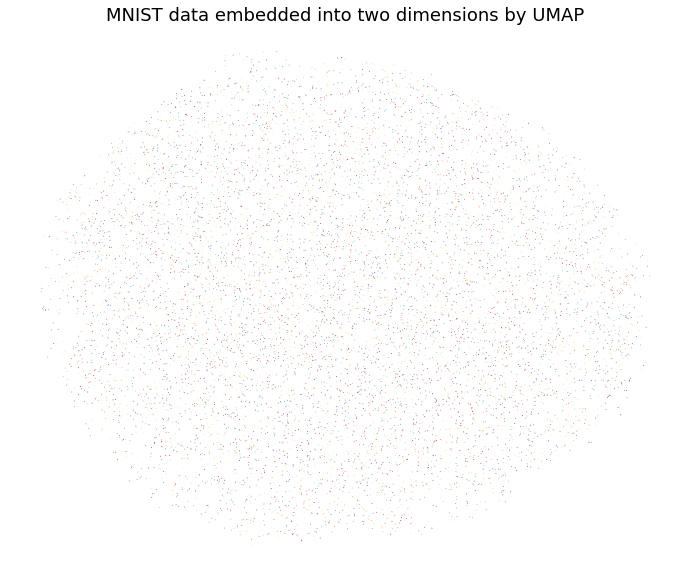

In [57]:
reducer = umap.UMAP()
#data=train_loader.dataset.data
#data=torch.reshape(data,(60000,784))
data=latent_repMNIST
color = label_mnist
#labels=list(train_loader.dataset.class_to_idx.values())
embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))

#
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')

plt.show()    

In [10]:
print('a','b','c',2,3)

a b c 2 3
